In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
dataset = load_iris()

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

GeForce 940MX
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [5]:
X = dataset.data
y = dataset.target

In [6]:
data = pd.DataFrame(X,columns=dataset.feature_names)

In [7]:
data['target'] = y

In [8]:
arr = np.asarray(data)

In [9]:
np.random.shuffle(arr)

In [10]:
sc = StandardScaler()

In [11]:
X = arr[:,:-1]
y = arr[:,-1]

In [12]:
X = sc.fit_transform(X)

In [13]:
enc = OneHotEncoder(sparse=False)

In [14]:
y = np.reshape(y,(y.shape[0],1))
y = enc.fit_transform(y)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.33, random_state=42)

In [16]:
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}, X_val: {X_val.shape}\ny_train: {y_train.shape}, y_test: {y_test.shape}, y_val: {y_val.shape}")

X_train: (100, 4), X_test: (33, 4), X_val: (17, 4)
y_train: (100, 3), y_test: (33, 3), y_val: (17, 3)


In [17]:
X_train = torch.tensor(X_train, dtype=torch.float, device=device)
X_test = torch.tensor(X_test, dtype=torch.float, device=device)
X_val = torch.tensor(X_val, dtype=torch.float, device=device)
y_train = torch.tensor(y_train, dtype=torch.float, device=device)
y_test = torch.tensor(y_test, dtype=torch.float, device=device)
y_val = torch.tensor(y_val, dtype=torch.float, device=device)

In [18]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 5)
        self.fc2 = nn.Linear(5,6)
        self.fc3 = nn.Linear(6,4)
        self.fc4 = nn.Linear(4,y_train.shape[1])
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x        

In [19]:
net = Model().to(device)

In [20]:
criterion = nn.MSELoss().to(device)
optimizer = optim.RMSprop(net.parameters(), lr=0.01)

In [21]:
def calculate_accuracy(y_pred, y_true):
    y_pred = y_pred.cpu().detach().numpy()
    y_true = y_true.cpu().detach().numpy()
    y_pred = enc.inverse_transform(y_pred)
    y_true = enc.inverse_transform(y_true)
    return (y_true == y_pred).sum() / len(y_true)

In [22]:
train_loss = []
valid_loss = []
train_acc = []
valid_acc = []
epochs = []
for i in tqdm(range(150)):
    optimizer.zero_grad()
    epochs.append(i)
    output = net(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    y_pred = net(X_val)
    loss_val = criterion(y_pred, y_val)

#     output = torch.squeeze(output)
    op_acc = calculate_accuracy(output, y_train)
#     y_pred = torch.squeeze(y_pred)
    valAcc = calculate_accuracy(y_pred, y_val)
    
    train_acc.append(op_acc)
    valid_acc.append(valAcc)
    valid_loss.append(loss_val.item())
    train_loss.append(loss.item())
    
    print(f"Epoch {i}:  training_acc: {op_acc:0.4f}, training loss: {loss:0.4f},  validation_acc: {valAcc:0.4f}, validation loss: {loss_val:0.4f}")
    

33%|███▎      | 49/150 [00:00<00:00, 228.12it/s]Epoch 0:  training_acc: 0.2900, training loss: 0.2507,  validation_acc: 0.4118, validation loss: 0.2361
Epoch 1:  training_acc: 0.2900, training loss: 0.2392,  validation_acc: 0.6471, validation loss: 0.2205
Epoch 2:  training_acc: 0.6500, training loss: 0.2200,  validation_acc: 0.6471, validation loss: 0.2022
Epoch 3:  training_acc: 0.6500, training loss: 0.1987,  validation_acc: 0.6471, validation loss: 0.1964
Epoch 4:  training_acc: 0.6500, training loss: 0.1871,  validation_acc: 0.6471, validation loss: 0.1785
Epoch 5:  training_acc: 0.6600, training loss: 0.1753,  validation_acc: 0.6471, validation loss: 0.1655
Epoch 6:  training_acc: 0.6600, training loss: 0.1614,  validation_acc: 0.6471, validation loss: 0.1496
Epoch 7:  training_acc: 0.6600, training loss: 0.1502,  validation_acc: 0.6471, validation loss: 0.1361
Epoch 8:  training_acc: 0.6600, training loss: 0.1393,  validation_acc: 0.6471, validation loss: 0.1226
Epoch 9:  traini

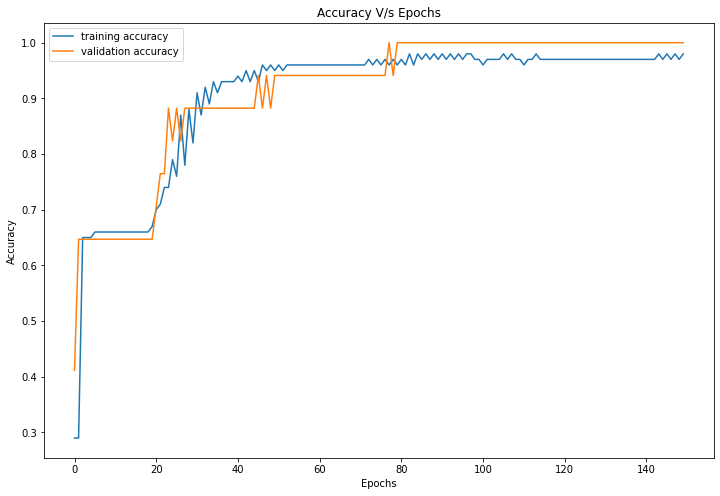

In [23]:
plt.figure(figsize=(12,8))
plt.plot(epochs, train_acc, label='training accuracy')
plt.plot(epochs, valid_acc, label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel("Accuracy")
plt.title('Accuracy V/s Epochs')
plt.legend()
plt.show()

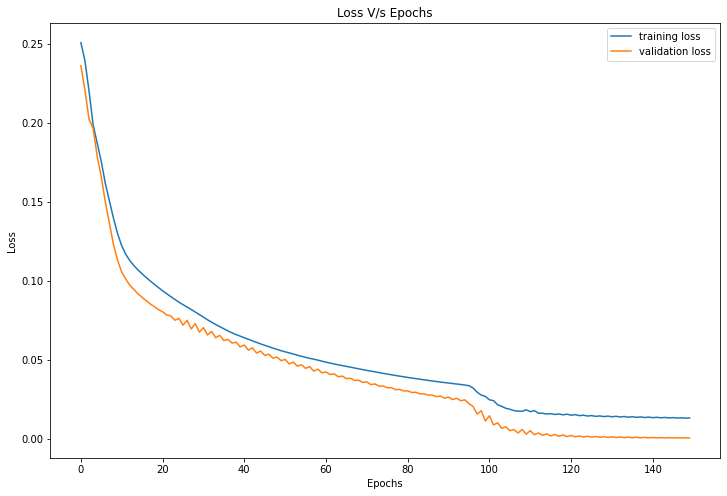

In [24]:
plt.figure(figsize=(12,8))
plt.plot(epochs, train_loss, label='training loss')
plt.plot(epochs, valid_loss, label='validation loss')
plt.xlabel('Epochs')
plt.ylabel("Loss")
plt.title('Loss V/s Epochs')
plt.legend()
plt.show()

In [25]:
y_pred = net(X_test)

In [26]:
y_pred = y_pred.cpu()
y_test = y_test.cpu()

In [27]:
y_pred = y_pred.detach().numpy()
y_pred = np.round(y_pred)

In [28]:
y_pred = enc.inverse_transform(y_pred)
y_test = enc.inverse_transform(y_test)

In [29]:
print(confusion_matrix(y_test, y_pred))

[[14  0  0]
 [ 0 10  0]
 [ 0  0  9]]


In [30]:
print(classification_report(y_test, y_pred))

precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        14
         1.0       1.00      1.00      1.00        10
         2.0       1.00      1.00      1.00         9

    accuracy                           1.00        33
   macro avg       1.00      1.00      1.00        33
weighted avg       1.00      1.00      1.00        33



In [31]:
(y_test==y_pred).sum()

33